In [2]:
# mask elevation and slope based on NLDAS forcing and elevation availability

import os
import numpy as np
import xarray as xr
import netCDF4 as nc
import gdal, ogr, osr
import subprocess
import matplotlib.pyplot as plt

#====================================================================================
# Main script
# root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/data/nldas_topo'
root_dir = '/glade/u/home/hongli/work/2020_04_21nldas_gmet/data/nldas_topo'
nldas_elev_file = 'NLDAS_elevation.nc4' # download from https://ldas.gsfc.nasa.gov/nldas/elevation
# nldas_force_file = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/data/nldas_daily_utc/NLDAS_2016.nc'
nldas_force_file = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/data/nldas_daily_utc_convert_summary/NLDAS_t_mean.nc'
ofile = 'NLDAS_topo.nc'
if os.path.exists(os.path.join(root_dir,ofile)):
    os.remove(os.path.join(root_dir,ofile))

#====================================================================================
# read NLDAS topography
f = xr.open_dataset(os.path.join(root_dir,nldas_elev_file))
lat = f['lat'].values[:] #(224)
lon = f['lon'].values[:] #(464)
NLDAS_elev = f['NLDAS_elev'].values[:] #(1,224,464)
NLDAS_slope = f['NLDAS_slope'].values[:] 
NLDAS_aspect = f['NLDAS_aspect'].values[:] 

# calculate gradient
gradient_n_s = np.multiply(NLDAS_slope,np.cos(np.radians(NLDAS_aspect)))
gradient_w_e = np.multiply(NLDAS_slope,np.sin(np.radians(NLDAS_aspect)))

#====================================================================================
# read NLDAS forcing and check consistency of NLDAS mask over time (1979-2019)
nldas_dir = os.path.join(root_dir,'data/nldas_daily_utc_convert_summary')
f_nldas = xr.open_dataset(nldas_force_file)
time = f_nldas['time'].values[:]
t_mean = f_nldas['t_mean'].values[:] # (time, y, x). unit: degC

# mask_ref = np.isnan(t_mean[0,:,:])
for i in range(1,t_mean.shape[0]):
    mask_before = np.isnan(t_mean[i-1,:,:])
    mask = np.isnan(t_mean[i,:,:])
    
    a=np.where(mask != mask_before)
    if len(a[0])!=0:
        print(time[i])

print('Use this forcing mask only if it is consistent over time')
#====================================================================================
# exclude grids that don't have forcing values or don't have elevation
# only keep the grid that have both forcing and elevation
overall_mask = ((np.isnan(t_mean[0:1,:,:])) | (np.isnan(NLDAS_elev))) #shape(1,224,464)

NLDAS_elev_ma = np.where(overall_mask==True,np.nan,NLDAS_elev)
NLDAS_slope_ma = np.where(overall_mask==True,np.nan,NLDAS_slope)
NLDAS_aspect_ma = np.where(overall_mask==True,np.nan,NLDAS_aspect)
gradient_n_s_ma = np.where(overall_mask==True,np.nan,gradient_n_s)
gradient_w_e_ma = np.where(overall_mask==True,np.nan,gradient_w_e)

#====================================================================================
# save
with nc.Dataset(os.path.join(root_dir,nldas_elev_file)) as src:
    with nc.Dataset(os.path.join(root_dir,ofile), "w") as dst:

        # copy dimensions
        for name, dimension in src.dimensions.items():
             dst.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None))

        include = ['lat', 'lon', 'time', 'NLDAS_elev', 'NLDAS_slope', 'NLDAS_aspect']
        for name, variable in src.variables.items():
            if name in include:
                x = dst.createVariable(name, variable.datatype, variable.dimensions)               
                dst[name].setncatts(src[name].__dict__)
                dst[name][:]=src[name][:] 
                
        vars_short = ['gradient_n_s','gradient_w_e']
        vars_standard_name = ['N_S_Slope','W_E_Slope']
        vars_long_name = ['Smoothed Topographic Gradient (Slope) from North to South',
                          'Smoothed Topographic Gradient (Slope) from West to East']

        for i, var in enumerate(vars_short):
            var_i = dst.createVariable(var,src['NLDAS_slope'].datatype,src['NLDAS_slope'].dimensions) # note: unlimited dimension is leftmost
            dst[var].setncatts(src['NLDAS_slope'].__dict__) # firstly copy all attributes
            var_i.standard_name = vars_standard_name[i] # modify some attributes
            var_i.long_name = vars_long_name[i]
            dst[var][:]=src['NLDAS_slope'][:] 
        
        dst.variables['NLDAS_elev'][:] = NLDAS_elev_ma
        dst.variables['NLDAS_slope'][:] = NLDAS_slope_ma
        dst.variables['NLDAS_aspect'][:] = NLDAS_aspect_ma
        
        dst.variables['gradient_n_s'][:] = gradient_n_s_ma
        dst.variables['gradient_w_e'][:] = gradient_w_e_ma
        
        dst.variables['gradient_n_s'].vmin = np.nanmin(gradient_n_s_ma)
        dst.variables['gradient_n_s'].vmax = np.nanmax(gradient_n_s_ma)
        
        dst.variables['gradient_w_e'].vmin = np.nanmin(gradient_w_e_ma)
        dst.variables['gradient_w_e'].vmax = np.nanmax(gradient_w_e_ma)        
        
print('Done')

Use this forcing mask only if it is consistent over time
Done


In [4]:
overall_mask = ((np.isnan(t_mean[0:1,:,:])) | (np.isnan(NLDAS_elev))) #shape(1,224,464)
mask1 = ((~np.isnan(t_mean[0:1,:,:])) & (np.isnan(NLDAS_elev))) #shape(1,224,464)
mask2 = ((np.isnan(t_mean[0:1,:,:])) & (~np.isnan(NLDAS_elev))) #shape(1,224,464)
mask3 = ((~np.isnan(t_mean[0:1,:,:])) & (~np.isnan(NLDAS_elev))) #shape(1,224,464)
print(mask1 in overall_mask, mask2 in overall_mask)
# np.where(mask3==overall_mask),np.where(np.isnan(t_mean[0:1,:,:]) != np.isnan(NLDAS_elev))

True True


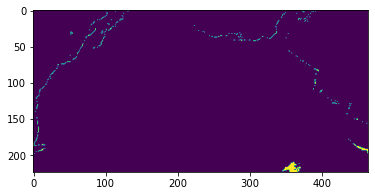

In [7]:
plt.imshow(np.isnan(t_mean[0,:,:]) != np.isnan(NLDAS_elev[0,:,:]))

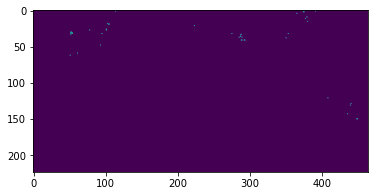

In [8]:
plt.imshow(np.isnan(t_mean[0,:,:]) & ~np.isnan(NLDAS_elev[0,:,:]))

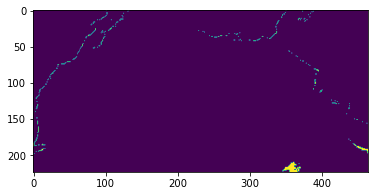

In [9]:
plt.imshow(~np.isnan(t_mean[0,:,:]) & np.isnan(NLDAS_elev[0,:,:]))

In [10]:
np.where(mask3==overall_mask)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

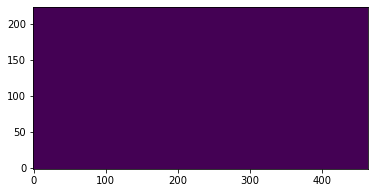

In [31]:
plt.imshow(((np.isnan(NLDAS_elev_new[0,:,:])) & (~np.isnan(tair_avg[0,:,:]))),origin='lower')
plt.show()